<a href="https://colab.research.google.com/github/Sreelekha08Dasgupta/Air_Quality_Prediction/blob/main/Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path ="/content/drive/MyDrive/Dataset/data.csv"

In [5]:
try:
    df = pd.read_csv(file_path)
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='ISO-8859-1')

print("Dataset Loaded Successfully!")
print(df.shape)
df.head()

Dataset Loaded Successfully!
(435742, 13)


/tmp/ipython-input-745991850.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='ISO-8859-1')


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [6]:
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

In [7]:
# Fill missing numeric values with mean
df.fillna(df.mean(numeric_only=True), inplace=True)
print("Missing values handled")

Missing values handled


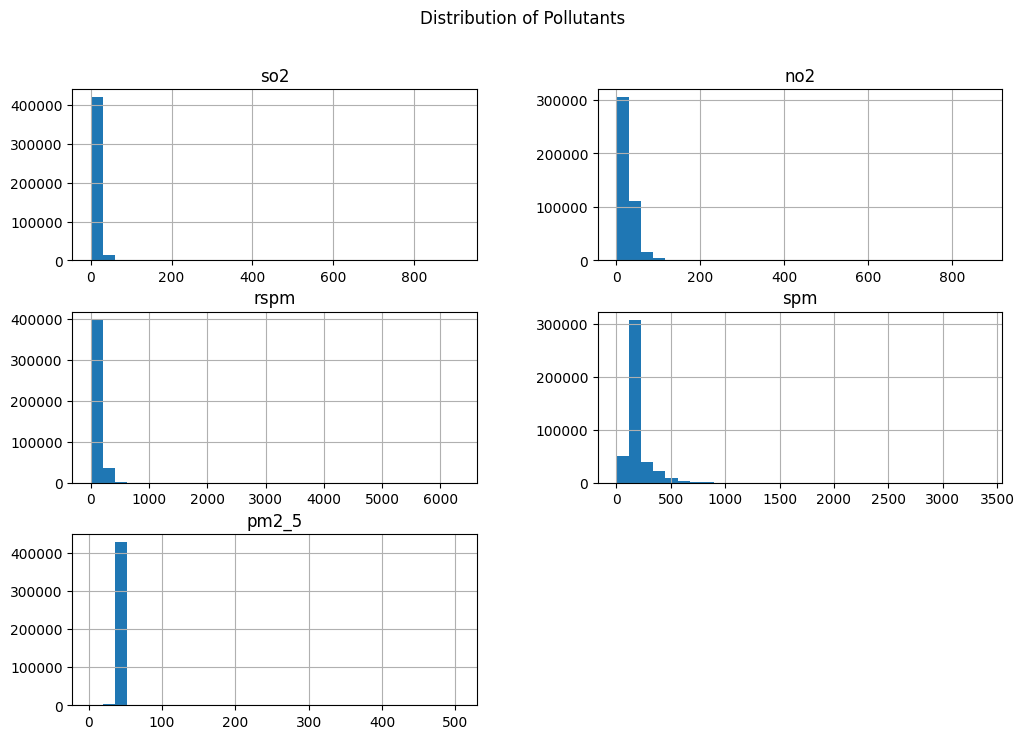

In [8]:
# Distribution of pollutants
df[['so2','no2','rspm','spm','pm2_5']].hist(bins=30, figsize=(12,8))
plt.suptitle("Distribution of Pollutants")
plt.show()

AQI_Category
Moderate     301726
Poor          81647
Good          48949
Very Poor      3118
Hazardous       302
Name: count, dtype: int64


/tmp/ipython-input-2117718409.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="AQI_Category", data=df, order=df["AQI_Category"].value_counts().index, palette="viridis")


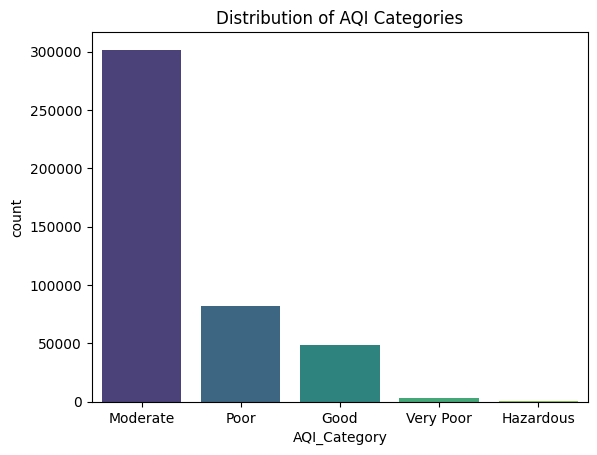

In [9]:
# Simple AQI calculation
df['AQI'] = df[['so2','no2','rspm','spm','pm2_5']].mean(axis=1)

# AQI categories
def get_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 200:
        return "Poor"
    elif aqi <= 300:
        return "Very Poor"
    else:
        return "Hazardous"

df['AQI_Category'] = df['AQI'].apply(get_category)

print(df['AQI_Category'].value_counts())
sns.countplot(x="AQI_Category", data=df, order=df["AQI_Category"].value_counts().index, palette="viridis")
plt.title("Distribution of AQI Categories")
plt.show()

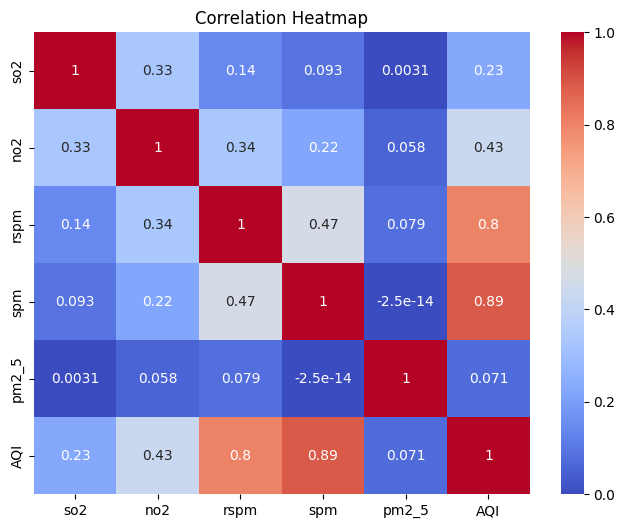

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['so2','no2','rspm','spm','pm2_5','AQI']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [11]:
# Features & labels
X = df[['so2','no2','rspm','spm','pm2_5']]
y = df['AQI_Category']

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Data prepared for ML")

Data prepared for ML


In [12]:
def plot_confusion_matrix(y_true, y_pred, labels, model_name, normalize=False):
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    fmt = '.2f' if normalize else 'd'
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name} ({'Normalized' if normalize else 'Raw'})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Logistic Regression Accuracy: 0.9994147953504917
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00      9790
   Hazardous       1.00      0.82      0.90        60
    Moderate       1.00      1.00      1.00     60346
        Poor       1.00      1.00      1.00     16329
   Very Poor       0.98      0.97      0.97       624

    accuracy                           1.00     87149
   macro avg       1.00      0.96      0.97     87149
weighted avg       1.00      1.00      1.00     87149



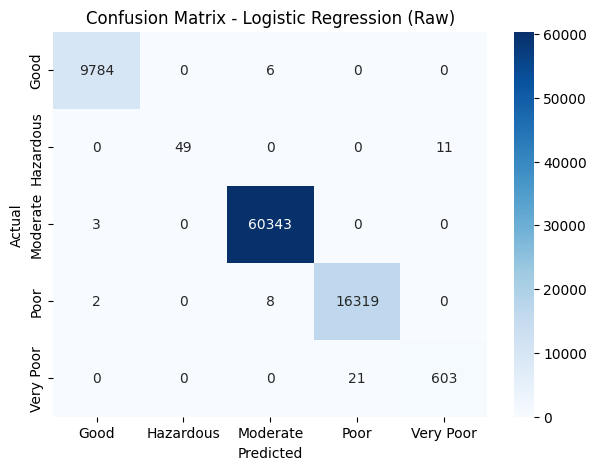

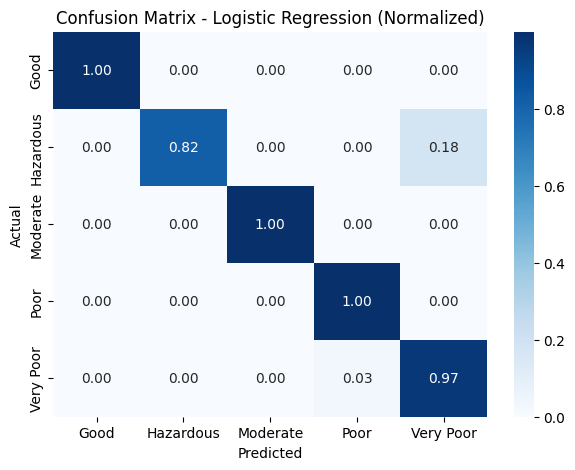

In [13]:
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

plot_confusion_matrix(y_test, y_pred_lr, le.classes_, "Logistic Regression")
plot_confusion_matrix(y_test, y_pred_lr, le.classes_, "Logistic Regression", normalize=True)

Random Forest Accuracy: 0.9951232945874308
              precision    recall  f1-score   support

        Good       0.99      0.99      0.99      9790
   Hazardous       0.98      0.92      0.95        60
    Moderate       1.00      1.00      1.00     60346
        Poor       0.99      0.99      0.99     16329
   Very Poor       0.97      0.95      0.96       624

    accuracy                           1.00     87149
   macro avg       0.99      0.97      0.98     87149
weighted avg       1.00      1.00      1.00     87149



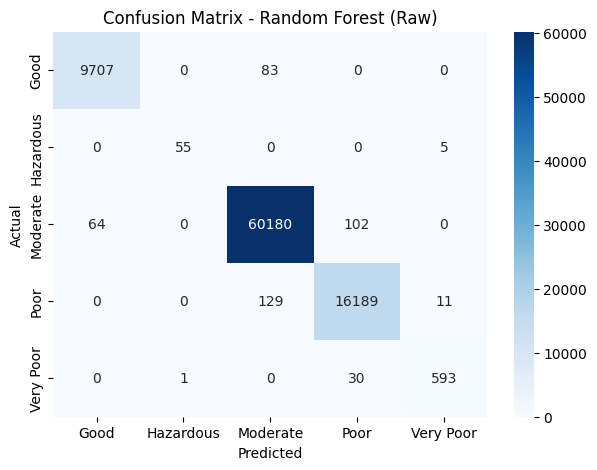

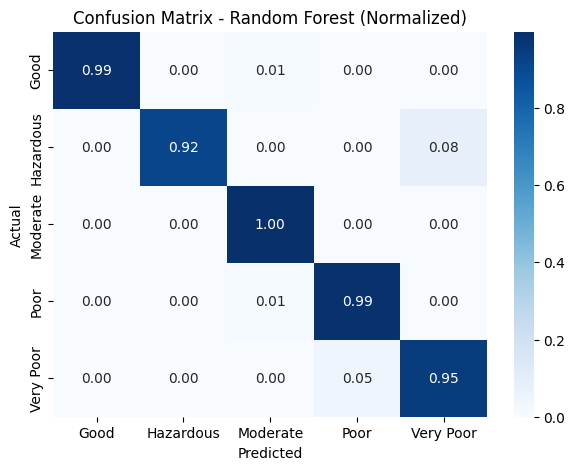

In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

plot_confusion_matrix(y_test, y_pred_rf, le.classes_, "Random Forest")
plot_confusion_matrix(y_test, y_pred_rf, le.classes_, "Random Forest", normalize=True)

SVM Accuracy: 0.9986345224844806
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00      9790
   Hazardous       1.00      0.95      0.97        60
    Moderate       1.00      1.00      1.00     60346
        Poor       1.00      1.00      1.00     16329
   Very Poor       0.99      0.97      0.98       624

    accuracy                           1.00     87149
   macro avg       1.00      0.98      0.99     87149
weighted avg       1.00      1.00      1.00     87149



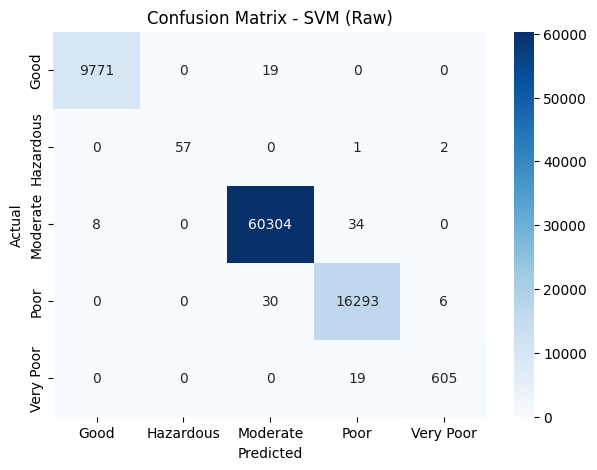

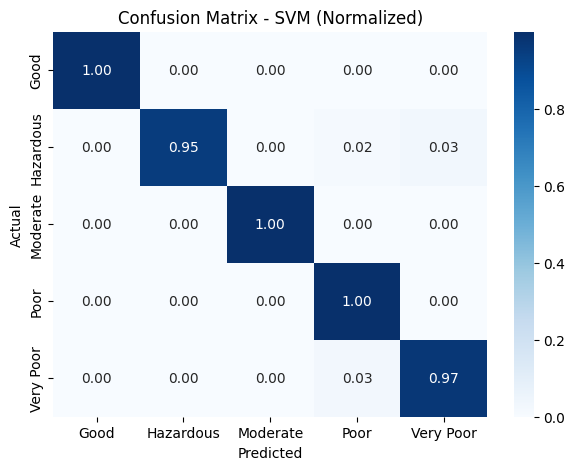

In [15]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

plot_confusion_matrix(y_test, y_pred_svm, le.classes_, "SVM")
plot_confusion_matrix(y_test, y_pred_svm, le.classes_, "SVM", normalize=True)


In [16]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=0)

nn_loss, nn_acc = model.evaluate(X_test, y_test, verbose=0)
print("Neural Network Accuracy:", nn_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network Accuracy: 0.9978771805763245


                 Model  Accuracy
0  Logistic Regression  0.999415
1        Random Forest  0.995123
2                  SVM  0.998635
3       Neural Network  0.997877


/tmp/ipython-input-3034357767.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Accuracy", palette="mako")


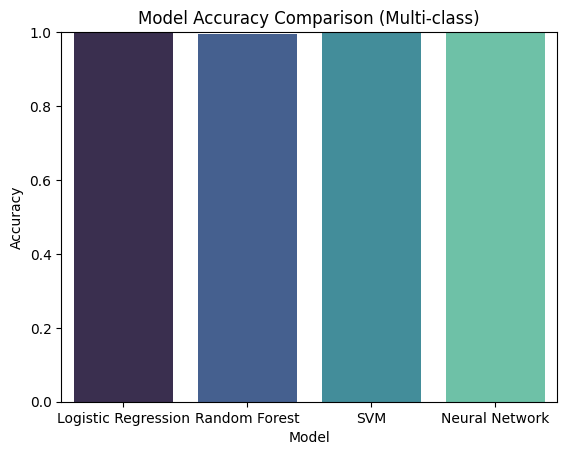

In [17]:
results = {
    "Logistic Regression": accuracy_score(y_test, y_pred_lr),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "SVM": accuracy_score(y_test, y_pred_svm),
    "Neural Network": nn_acc
}

results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print(results_df)

sns.barplot(data=results_df, x="Model", y="Accuracy", palette="mako")
plt.title("Model Accuracy Comparison (Multi-class)")
plt.ylim(0,1)
plt.show()


Air_Safety
Safe      350675
Unsafe     85067
Name: count, dtype: int64


/tmp/ipython-input-3406511681.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Air_Safety", data=df, palette="coolwarm")


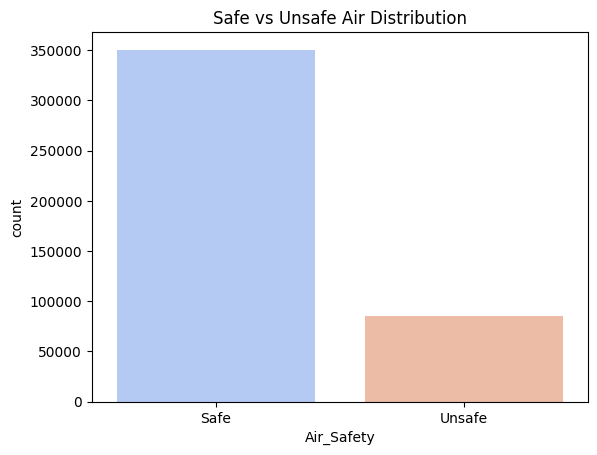

In [18]:
def safe_or_unsafe(cat):
    return "Safe" if cat in ["Good", "Moderate"] else "Unsafe"

df["Air_Safety"] = df["AQI_Category"].apply(safe_or_unsafe)
print(df["Air_Safety"].value_counts())
sns.countplot(x="Air_Safety", data=df, palette="coolwarm")
plt.title("Safe vs Unsafe Air Distribution")
plt.show()


In [19]:
X_bin = df[['so2','no2','rspm','spm','pm2_5']]
y_bin = df['Air_Safety']

le_bin = LabelEncoder()
y_bin = le_bin.fit_transform(y_bin)  # Safe=0, Unsafe=1

X_bin_scaled = scaler.fit_transform(X_bin)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bin_scaled, y_bin, test_size=0.2, random_state=42, stratify=y_bin)


Logistic Regression (Binary) Accuracy: 0.999954101596117
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00     70135
      Unsafe       1.00      1.00      1.00     17014

    accuracy                           1.00     87149
   macro avg       1.00      1.00      1.00     87149
weighted avg       1.00      1.00      1.00     87149



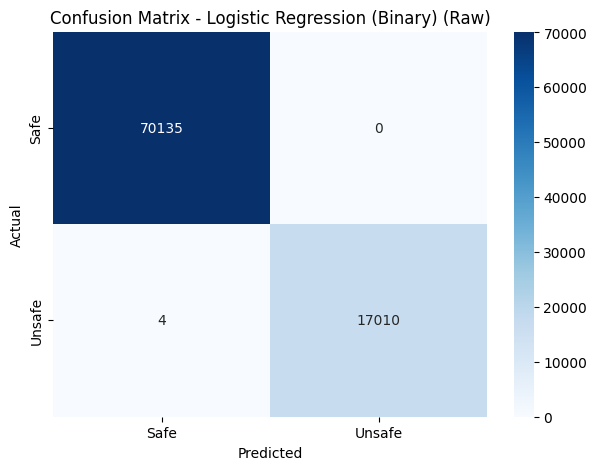

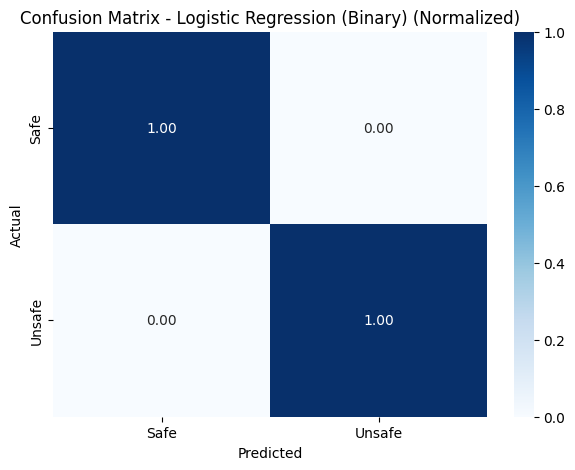

In [20]:
log_bin = LogisticRegression(max_iter=500)
log_bin.fit(Xb_train, yb_train)
yb_pred_lr = log_bin.predict(Xb_test)

print("Logistic Regression (Binary) Accuracy:", accuracy_score(yb_test, yb_pred_lr))
print(classification_report(yb_test, yb_pred_lr, target_names=le_bin.classes_))

plot_confusion_matrix(yb_test, yb_pred_lr, le_bin.classes_, "Logistic Regression (Binary)")
plot_confusion_matrix(yb_test, yb_pred_lr, le_bin.classes_, "Logistic Regression (Binary)", normalize=True)


Random Forest (Binary) Accuracy: 0.9972690449689612
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00     70135
      Unsafe       0.99      0.99      0.99     17014

    accuracy                           1.00     87149
   macro avg       1.00      1.00      1.00     87149
weighted avg       1.00      1.00      1.00     87149



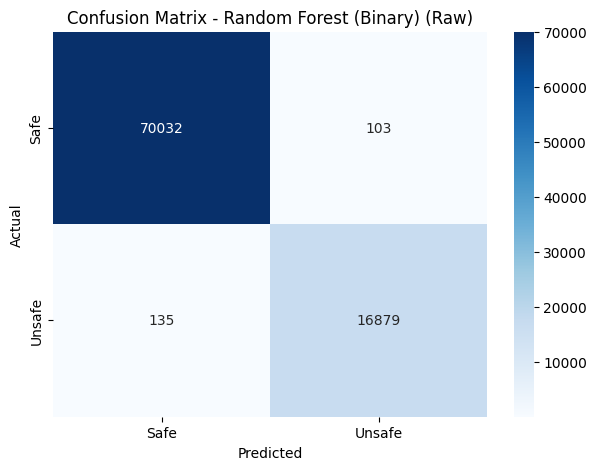

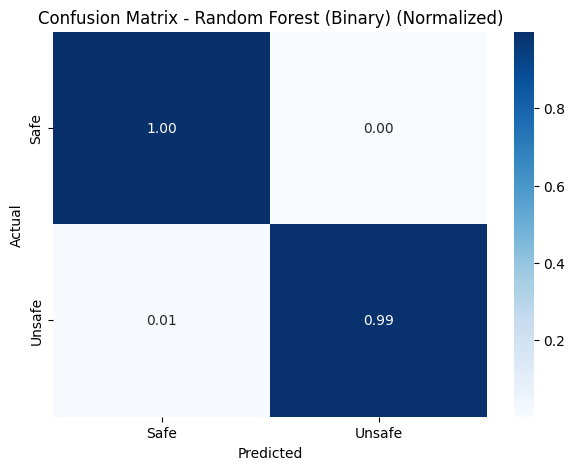

In [21]:
rf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bin.fit(Xb_train, yb_train)
yb_pred_rf = rf_bin.predict(Xb_test)

print("Random Forest (Binary) Accuracy:", accuracy_score(yb_test, yb_pred_rf))
print(classification_report(yb_test, yb_pred_rf, target_names=le_bin.classes_))

plot_confusion_matrix(yb_test, yb_pred_rf, le_bin.classes_, "Random Forest (Binary)")
plot_confusion_matrix(yb_test, yb_pred_rf, le_bin.classes_, "Random Forest (Binary)", normalize=True)


In [22]:
model_bin = Sequential([
    Dense(32, activation='relu', input_shape=(Xb_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_bin.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bin = model_bin.fit(Xb_train, yb_train, validation_data=(Xb_test, yb_test), epochs=20, batch_size=32, verbose=0)

nn_loss_bin, nn_acc_bin = model_bin.evaluate(Xb_test, yb_test, verbose=0)
print("Neural Network (Binary) Accuracy:", nn_acc_bin)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network (Binary) Accuracy: 0.998519778251648


                          Model  Accuracy
0  Logistic Regression (Binary)  0.999954
1        Random Forest (Binary)  0.997269
2       Neural Network (Binary)  0.998520


/tmp/ipython-input-2022199825.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_bin_df, x="Model", y="Accuracy", palette="Set2")


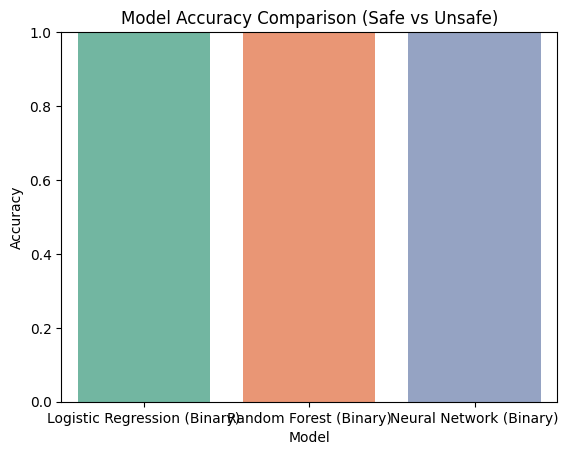

In [23]:
results_bin = {
    "Logistic Regression (Binary)": accuracy_score(yb_test, yb_pred_lr),
    "Random Forest (Binary)": accuracy_score(yb_test, yb_pred_rf),
    "Neural Network (Binary)": nn_acc_bin
}

results_bin_df = pd.DataFrame(list(results_bin.items()), columns=["Model", "Accuracy"])
print(results_bin_df)

sns.barplot(data=results_bin_df, x="Model", y="Accuracy", palette="Set2")
plt.title("Model Accuracy Comparison (Safe vs Unsafe)")
plt.ylim(0,1)
plt.show()


In [26]:
# Multi-class
best_model_multi = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"Best Multi-class Model: {best_model_multi['Model']} with Accuracy: {best_model_multi['Accuracy']:.4f}")

# Binary
best_model_bin = results_bin_df.loc[results_bin_df['Accuracy'].idxmax()]
print(f"Best Binary Model: {best_model_bin['Model']} with Accuracy: {best_model_bin['Accuracy']:.4f}")


Best Multi-class Model: Logistic Regression with Accuracy: 0.9994
Best Binary Model: Logistic Regression (Binary) with Accuracy: 1.0000
